In [ ]:
# From C:\Berkeley\DATA\june23_24\clustering_etc\chatgpt2

In [1]:
# -*- coding: utf-8 -*-
#import skbeam
import sys
import os
#sys.path.append('C:\Berkeley\DATA\cosmic_tpx3\module_file')
# This creates a path to the 'scripts' folder
# os.path.abspath('..') gets the path to the parent directory (speckle_time_series)
# os.path.join then adds 'scripts' to that path
scripts_path = os.path.join(os.path.abspath('..'), 'scripts')
# This adds the 'scripts' folder to the list of paths Python looks in for modules
if scripts_path not in sys.path:
    sys.path.append(scripts_path)
import tpx3_module_2 as tpx3_2
import clustering_function_file as clst

from skbeam.core import correlation as corr
import skbeam
import pickle as pickle
import matplotlib.pyplot as plt
import numpy as np


from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm

import matplotlib.patches as mp
from matplotlib import cm


import cv2
from skimage.util import img_as_float, img_as_ubyte

import skbeam.core.roi as roi
#import pycorrelate as pyc

import struct as struct
import pandas as pd 
from astropy.io import fits
import re
from pandas.plotting import autocorrelation_plot
import multipletau
from tqdm.notebook import trange, tqdm
from skimage import measure, color, io
from scipy import ndimage
import matplotlib.patches as patches
from PIL import Image
from scipy.stats import t
from statsmodels.tsa.stattools import adfuller


C:\ProgramData\Anaconda3\lib\site-packages\pycorrelate\pycorrelate.py:118: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def ucorrelate(t, u, maxlag=None):


# load data file
### The following calcualtions were conducted using photon arrival data whose size is around 5 GB or (30 minute experiment duration). The data file 'SampleShortData.csv' takes only 1000 photon ### arrivals.

In [10]:
data_folder_path = os.path.join(os.path.abspath('..'), 'data')
# This adds the 'scripts' folder to the list of paths Python looks in for modules
if data_folder_path not in sys.path:
    sys.path.append(data_folder_path)
filename = r'SampleShortData.csv' #r'SampleData.csv'
file_path = os.path.join(data_folder_path, filename)

data_raw = pd.read_csv(file_path)


### '1did' is the x,y coordiante and 't' is the time stamp in 200ns 
### 1did = y * 512 + x
### x = 1did % 512 and  y = 1did // 512
### actual photon time stamp = (t * 200 ) ns

In [14]:

data_raw


,1did,t
0,230728,814
1,228704,900
2,228703,900
3,134059,917
4,133548,917
...,...,...
247337161,157138,4294967223
247337162,157139,4294967223
247337163,186644,4294967258
247337164,186646,4294967258


### Sort Data based based on photon arrival time
### mask_remover[1] is a summed image where photon arrived at all pixels for the entire experiment duration is stored. 


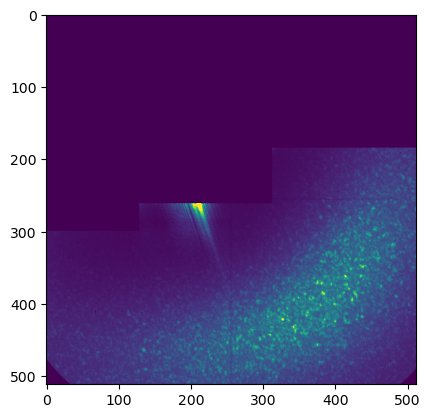

In [16]:
data_sorted = data_raw.sort_values(by = 't', ascending = True)
mask_remover = tpx3_2.imager_mask_remover(data_sorted , 0, 10000) # 0 and 1000 are used to set the contrast level 

## all the time stamps are grouped by their x,y coordinates

In [18]:
mask_remover[0]

,1did,PhNo,ts,x,y
0,300,726.0,"[3493196, 17416202, 21296648, 34077299, 397433...",300,0
1,301,725.0,"[6141862, 21296648, 29700320, 39743391, 446567...",301,0
2,302,703.0,"[6141862, 8227237, 29700320, 34001623, 3563869...",302,0
3,303,657.0,"[1551955, 8227237, 34001623, 35638695, 4100446...",303,0
4,304,613.0,"[8227237, 21504215, 30915686, 41004464, 655360...",304,0
...,...,...,...,...,...
262139,261815,0.0,NaN,183,511
262140,261816,0.0,NaN,184,511
262141,262139,0.0,NaN,507,511
262142,262140,0.0,NaN,508,511


### For thresholding and detecting speckles, the summed image needs to be normalized between 0 and 255. It's a requirement for the CV2 package. 


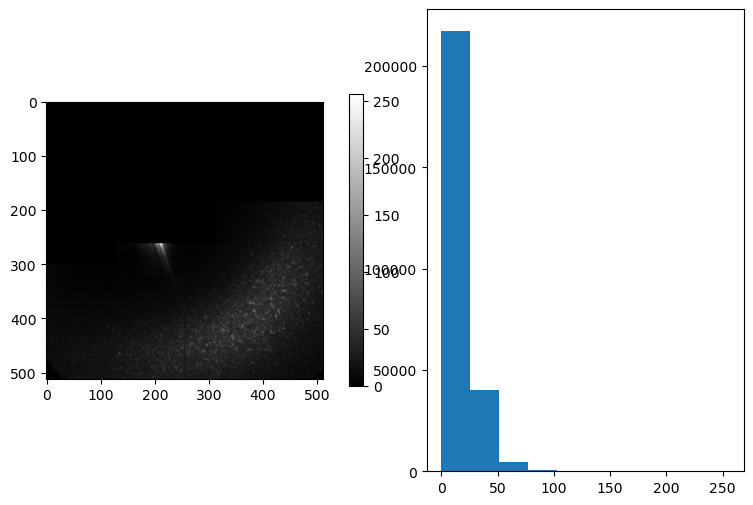

In [19]:
normalized_array_full = clst.full_image_for_speckle_detection(mask_remover[1])

# q-ring selection
### Create a q-ring which is basically an ROI. The goal is to select all the data (photon timestamps and coordiantes) within the q-ring.
### 

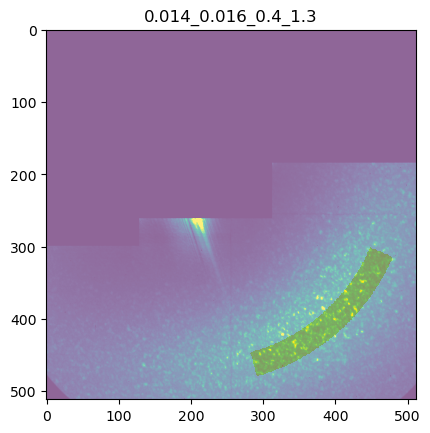

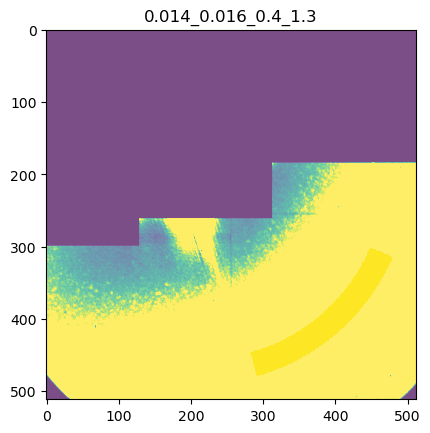

In [20]:
q1 = tpx3_2.q_roi_viewer_new(mask_remover[1], (201,213), 
                          1, 0.014, 0.016, 0.4, 1.3, vm1 = 800, vm2 = 8000)
q1_ts =tpx3_2.timestamps_from_ring_movie(mask_remover[0], mask_remover[1], (201,213), 
                        1, 0.014, 0.016, 0.4, 1.3,
                         flattened = False, after_extraction_plot=False)

### We are going to detect speckles within q-ring. It's needed to normalize the q-ring image

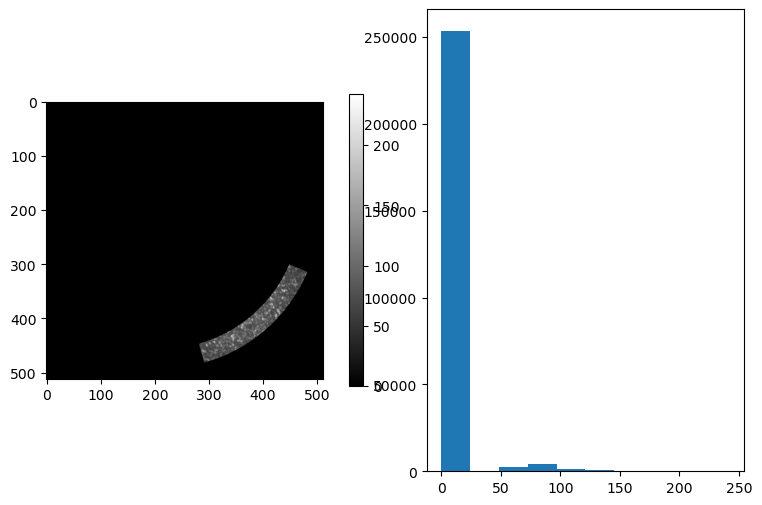

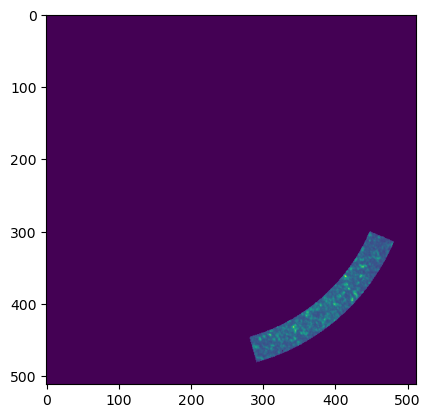

In [22]:
q1_image_norm, q1image, q1df = clst.qring_image_for_speckle_detection(q1_ts[1])


# Identify speckles

Area of Each Speckle: [5.5, 0.5, 3.0, 0.0, 1.5, 0.0, 15.5, 28.5, 11.5, 0.0, 1.5, 9.5, 13.0, 26.0, 0.0, 9.5, 0.0, 2.0, 12.5, 31.5, 4.5, 0.0, 4.0, 3.0, 0.0, 14.5, 56.0, 78.0, 3.0, 1.0, 16.0, 2.0, 0.0, 6.5, 3.5, 1.5, 9.5, 6.0, 3.0, 79.5, 6.5, 0.0, 1.0, 3.5, 135.0, 6.0, 27.5, 110.5, 0.0, 0.5, 42.0, 3.0, 49.0, 1.0, 1.0, 0.5, 55.0, 5.5, 1.0, 0.0, 20.5, 0.0, 39.0, 1.5, 0.0, 2.0, 15.5, 36.0, 13.0, 8.5, 0.5, 21.0, 0.5, 1.0, 7.5, 11.5, 1.0, 0.0, 0.5, 6.5]
Total No of identified Speckles 80
No of Chosen Speckles: 46


Text(0, 0.5, 'Freq')

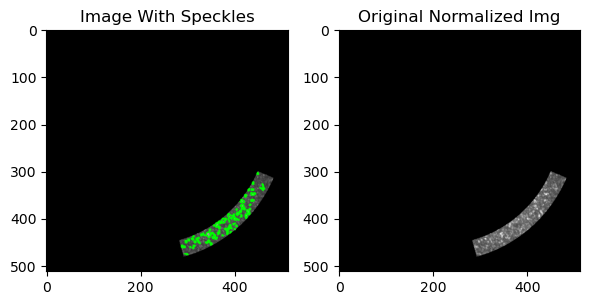

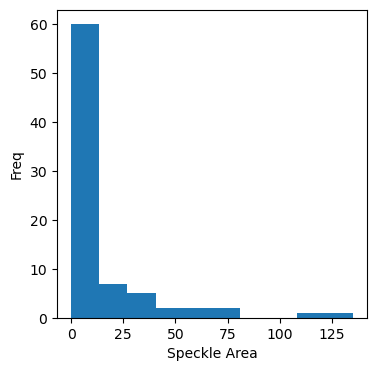

In [30]:
output_image, speckles, areas = clst.speckle_finder_cv2(q1_image_norm, (3,3), 0,  100, 2, 150)
print('Area of Each Speckle:', areas)
print('Total No of identified Speckles', len(areas))
print('No of Chosen Speckles:',len(speckles))
%matplotlib inline
#fig, ax = plt.subplots(2,2, figsize = (9,6))
plt.figure(figsize = (6,6))
plt.subplot(121)
plt.imshow(output_image, vmin = 0, vmax = 200)
#plt.title('speckle_finder_cv2_wBlurring')
plt.title('Image With Speckles')

plt.subplot(122)
plt.imshow(q1_image_norm, cmap = 'gray', vmin = 0, vmax = 200)
plt.title('Original Normalized Img')
plt.tight_layout()

plt.figure(figsize = (4,4))
plt.hist(areas)
plt.xlabel('Speckle Area')
plt.ylabel('Freq')

No. of bins:  858 EachBinDuration:  1.001097303
No. of bins:  858 EachBinDuration:  1.00112439
No. of bins:  858 EachBinDuration:  1.001125616
No. of bins:  858 EachBinDuration:  1.001117949
No. of bins:  858 EachBinDuration:  1.001126443
No. of bins:  858 EachBinDuration:  1.001069752
No. of bins:  858 EachBinDuration:  1.00111636
No. of bins:  858 EachBinDuration:  1.001132163
No. of bins:  858 EachBinDuration:  1.001120703
No. of bins:  858 EachBinDuration:  1.001107278
No. of bins:  858 EachBinDuration:  1.001129552
No. of bins:  858 EachBinDuration:  1.001086117
No. of bins:  858 EachBinDuration:  1.001096144
No. of bins:  858 EachBinDuration:  1.001086613
No. of bins:  858 EachBinDuration:  1.001114151
No. of bins:  858 EachBinDuration:  1.001133888
No. of bins:  858 EachBinDuration:  1.001131509
No. of bins:  858 EachBinDuration:  1.0011044
No. of bins:  858 EachBinDuration:  1.00111331
No. of bins:  858 EachBinDuration:  1.001125286
No. of bins:  858 EachBinDuration:  1.0011286

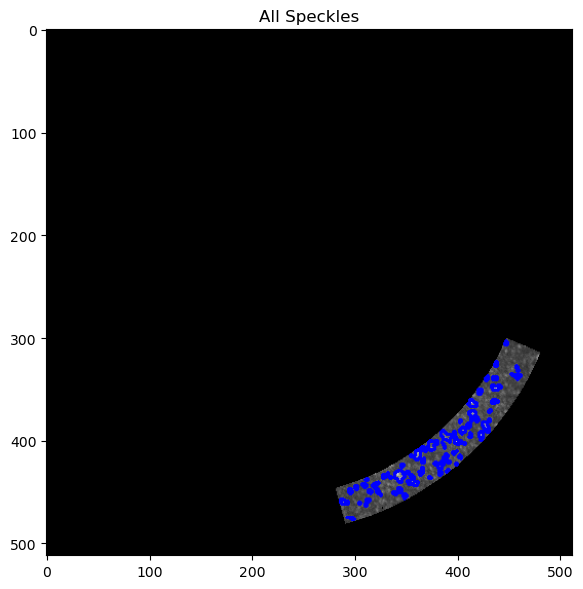

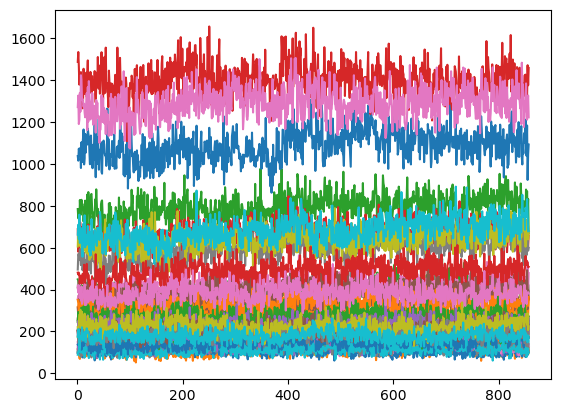

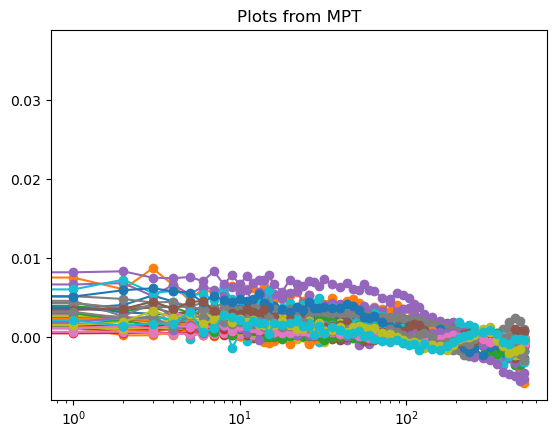

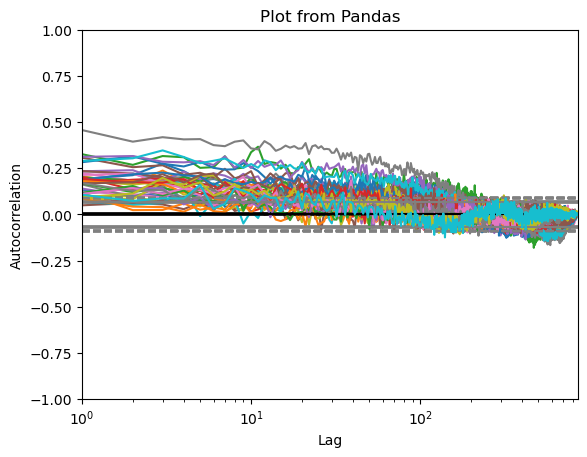

In [31]:
#q1_250_bin, q1_250_pandas, q1_250_mpt, q1_spdict, q1_allspeckles =  ac_calculator_speckles(speckles, q1_image_norm, mask_remover250[0], 1e9, 1)
#q1_250_bin, q1_250_pandas, q1_250_mpt, q1_spdict, q1_allspeckles =  ac_calculator_speckles_onlystationary(speckles, q1_image_norm, mask_remover250[0], 1e9, 1, 0.05)
#For15min only stationary
q1_bin, q1_pandas, q1_mpt, q1_spdict, q1_allspeckles =  clst.ac_calculator_speckles_onlystationary(speckles, 
                                                                            q1_image_norm, mask_remover[0],  1e9, 1, 0.05)



In [ ]:
#pval_q1 = clst.pval_plotter(q1_binNsp, 0.05) # when normalizing with beam it is creating more non_stationarity

In [33]:
# calculate the z value,.i.e., the horizontal line in the acf plots
# Formula ci95 = z95/np.sqrt(N), z95 = 1.96, z99 = 2.57
ci95 = np.round(1.96 / np.sqrt(q1_bin[0].dropna().shape[0]),3)
ci95

0.067

dict_keys([0, 1, 3, 15, 17, 18, 24, 28, 29, 31, 34])


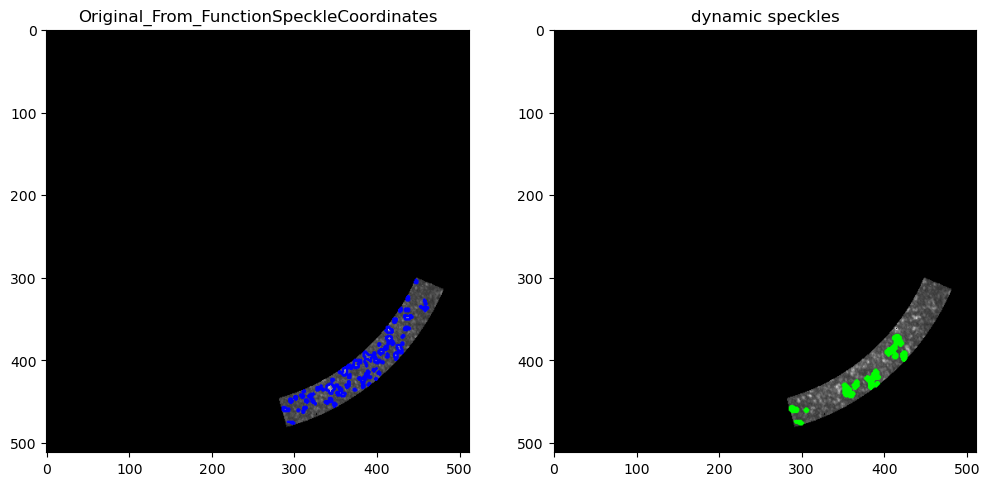

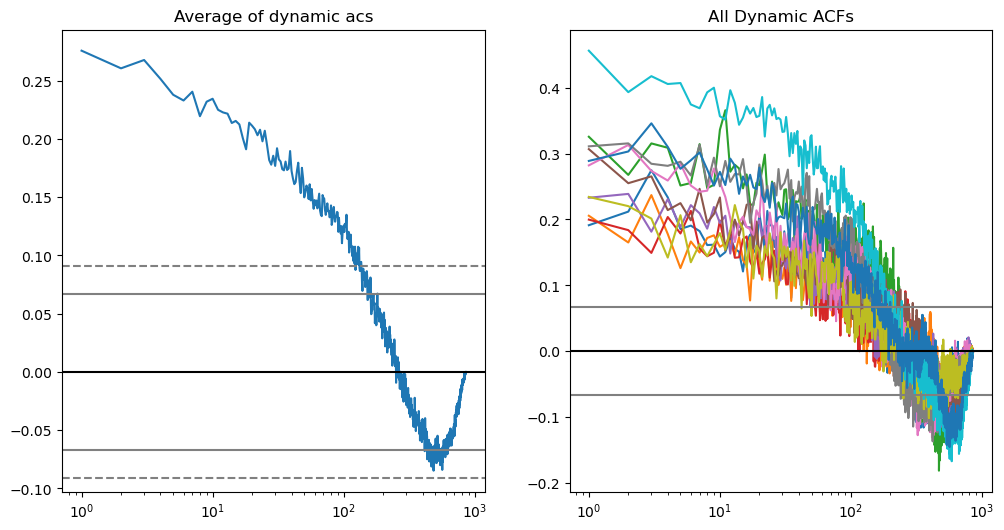

In [34]:
q1_dynamic_ac, q1_dynamic_dict, q1_dynamic_coords, q1_dynamic_ci, q1_avg_ac  = clst.dynamic_speckle_finder_3(q1_pandas, q1_spdict, 
                                                                                                q1_image_norm,  q1_allspeckles, 200, ci95 )


In [36]:
pvals_dynamic_q1_woNorm = clst.pval_plotter_dynamic(q1_bin, q1_dynamic_ac.keys())

0:0.0 ADF -6.517  : Stationary
1:0.013 ADF -3.347  : Stationary
3:0.016 ADF -3.275  : Stationary
15:0.0 ADF -4.474  : Stationary
17:0.0 ADF -4.486  : Stationary
18:0.017 ADF -3.263  : Stationary
24:0.0 ADF -4.395  : Stationary
28:0.033 ADF -3.02  : Stationary
29:0.003 ADF -3.813  : Stationary
31:0.019 ADF -3.22  : Stationary
34:0.023 ADF -3.153  : Stationary


In [37]:
all_q1250_bokeh = clst.bokeh_plotter(
    [val['ac'].values for key,val in q1_pandas.items()],
    q1_pandas.keys(),
    q1_pandas[0]['lag'].values)

In [ ]:
dynamic_q1250_bokeh_ci = bokeh_plotter_with_ci(
    [val['ac'].values for key,val in q1_250_dynamic_ac.items()],
    q1_250_dynamic_ac.keys(),
    q1_250_dynamic_ac[0]['lag'].values, q1_250_dynamic_ci)

# output 

In [38]:
q1_par = [0.014,0.016,0.4,1.3]


In [40]:
out_test = pd.DataFrame({ 
        'q1':{'q1_coord': q1_par, 'q1_image_norm': q1_image_norm , 'q1_bin': q1_bin, 'q1_pandas': q1_pandas, 'q1_mpt': q1_mpt, 'q1_spdict': q1_spdict, 'q1_allspeckles': q1_allspeckles ,
                          'q1_avg': q1_avg_ac, 'q1_misc': [1e9, 1],
             'q1_dynamic_ac': q1_dynamic_ac, 'q1_dynamic_coords': q1_dynamic_coords, 'q1_dynamic_ci': q1_dynamic_ci}}
                     )

In [41]:
#with open('{}{}'.format('sample_result_file','.pkl' ), 'wb') as outfile:
#    pickle.dump(out_test, outfile, pickle.HIGHEST_PROTOCOL)
#outfile.close()